In [2]:
# Import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('max_column', 1000)

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/covid-19/Train_maskedv2.csv
/kaggle/input/covid-19/Test_maskedv2.csv
/kaggle/input/covid-19/variable_descriptions_v2.csv
/kaggle/input/covid-19/samplesubmissionv2.csv


In [4]:
train = pd.read_csv('/kaggle/input/covid-19/Train_maskedv2.csv')
test = pd.read_csv('/kaggle/input/covid-19/Test_maskedv2.csv')
sample = pd.read_csv('/kaggle/input/covid-19/samplesubmissionv2.csv')
description = pd.read_csv('/kaggle/input/covid-19/variable_descriptions_v2.csv')

In [5]:
pd.set_option('max_colwidth', 200)
pd.set_option('max_info_rows', 1000)

In [6]:
train.drop(columns=['dw_12', 'dw_13', 'lan_13'], inplace=True)
test.drop(columns=['dw_12', 'dw_13', 'lan_13'], inplace=True)

In [7]:
train_len = len(train)
data=pd.concat([train,test])

In [8]:
data['rich'] = data['car_01']+data['stv_01']+data['psa_01']+data['dw_02']+data['lln_00']
data['poor'] = data['car_00'] +data['stv_00']+data['psa_00']+data['dw_01']+data['lln_01']

In [9]:
data['household_size'] =data['total_individuals'] / data['total_households']

In [10]:
from sklearn.cluster import KMeans
columns=data.drop(["target_pct_vunerable","ward"],1).columns

data_km=data[columns].copy()

data_km["total_households"]/=data_km["total_households"].max()
data_km["total_individuals"]/=data_km["total_individuals"].max()

km=KMeans(15,random_state=2019)
data["cluster"]=km.fit_predict(data_km[columns])

In [11]:
train = data[:train_len]
test = data[train_len:]

In [12]:
_id = test['ward']
test.drop(columns=['target_pct_vunerable','ward'], inplace=True)
train.drop(columns=['ward'], inplace=True)

In [13]:
train.shape, test.shape

((3174, 50), (1102, 49))

In [14]:
train['total_households'] = np.log10(train['total_households'])
test['total_households'] = np.log10(test['total_households'])

train['total_individuals'] = np.log10(train['total_individuals'])
test['total_individuals'] = np.log10(test['total_individuals'])

In [15]:
X = train.drop(columns=['target_pct_vunerable'])
y = train['target_pct_vunerable']

In [16]:
X.columns

Index(['car_00', 'car_01', 'dw_00', 'dw_01', 'dw_02', 'dw_03', 'dw_04',
       'dw_05', 'dw_06', 'dw_07', 'dw_08', 'dw_09', 'dw_10', 'dw_11', 'lan_00',
       'lan_01', 'lan_02', 'lan_03', 'lan_04', 'lan_05', 'lan_06', 'lan_07',
       'lan_08', 'lan_09', 'lan_10', 'lan_11', 'lan_12', 'lan_14', 'lgt_00',
       'lln_00', 'lln_01', 'pg_00', 'pg_01', 'pg_02', 'pg_03', 'pg_04',
       'psa_00', 'psa_01', 'psa_02', 'psa_03', 'psa_04', 'stv_00', 'stv_01',
       'total_households', 'total_individuals', 'rich', 'poor',
       'household_size', 'cluster'],
      dtype='object')

In [17]:
X.isna().sum().any()

False

In [18]:
col = ['car_00', 'car_01', 'dw_00', 'dw_01', 'dw_02', 'dw_03', 'dw_04',
       'lan_08', 'lan_09', 'lan_10', 'lan_11', 'lan_12', 'lan_14', 'lgt_00',
       'dw_05', 'dw_06', 'dw_07', 'dw_08', 'dw_09', 'dw_10', 'dw_11', 'lan_00',
       'lan_01', 'lan_02', 'lan_03', 'lan_04', 'lan_05', 'lan_06', 'lan_07',
       'lln_00', 'lln_01', 'pg_00', 'pg_01', 'pg_02', 'pg_03', 'pg_04',
       'psa_00', 'psa_01', 'psa_02', 'psa_03', 'psa_04', 'stv_00', 'stv_01',
        'rich', 'poor']

In [19]:
X[col] = X[col].round(2)
test[col] = test[col].round(2)

In [20]:
categorical_features_indices = np.where(X.dtypes != np.float)[0]; categorical_features_indices

array([48])

In [21]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold,StratifiedKFold, TimeSeriesSplit

testsplit_store=[]
test_store=[]
fold=KFold(n_splits=15, shuffle=True, random_state=123456)
i=1
for train_index, test_index in fold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    cat = CatBoostRegressor(n_estimators=10000,eval_metric='RMSE', learning_rate=0.0801032, random_seed= 123456, l2_leaf_reg=4, use_best_model=True)
    cat.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=300,verbose=100, cat_features=categorical_features_indices)
    predict = cat.predict(X_test)
    print("err: ",np.sqrt(mean_squared_error(y_test,predict)))
    testsplit_store.append(np.sqrt(mean_squared_error(y_test,predict)))
    pred = cat.predict(test)
    test_store.append(pred)

0:	learn: 12.1780208	test: 12.1780208	test1: 13.1044743	best: 13.1044743 (0)	total: 65ms	remaining: 10m 50s
100:	learn: 5.6174210	test: 5.6132629	test1: 5.5393814	best: 5.5390735 (95)	total: 1.03s	remaining: 1m 40s
200:	learn: 4.4863793	test: 4.4817942	test1: 5.2740907	best: 5.2546821 (190)	total: 1.7s	remaining: 1m 22s
300:	learn: 3.7980081	test: 3.8010415	test1: 5.1792462	best: 5.1792462 (300)	total: 2.34s	remaining: 1m 15s
400:	learn: 3.3354550	test: 3.3414800	test1: 5.1836335	best: 5.1401847 (337)	total: 3.08s	remaining: 1m 13s
500:	learn: 2.9796511	test: 2.9941472	test1: 5.1514855	best: 5.1401847 (337)	total: 3.72s	remaining: 1m 10s
600:	learn: 2.6944624	test: 2.7120810	test1: 5.1254947	best: 5.0991047 (565)	total: 4.38s	remaining: 1m 8s
700:	learn: 2.4449726	test: 2.4651235	test1: 5.1370228	best: 5.0991047 (565)	total: 5.05s	remaining: 1m 6s
800:	learn: 2.2272654	test: 2.2494634	test1: 5.1422417	best: 5.0991047 (565)	total: 5.7s	remaining: 1m 5s
Stopped by overfitting detector  (

100:	learn: 5.6500582	test: 5.6462445	test1: 5.5829240	best: 5.5808798 (97)	total: 698ms	remaining: 1m 8s
200:	learn: 4.5038284	test: 4.5024083	test1: 5.2638024	best: 5.2471986 (191)	total: 1.47s	remaining: 1m 11s
300:	learn: 3.8312455	test: 3.8361575	test1: 5.2299376	best: 5.2065719 (292)	total: 2.11s	remaining: 1m 8s
400:	learn: 3.3778261	test: 3.3844706	test1: 5.1106617	best: 5.1106617 (400)	total: 2.75s	remaining: 1m 5s
500:	learn: 2.9666562	test: 2.9818421	test1: 5.0801412	best: 5.0637373 (476)	total: 3.41s	remaining: 1m 4s
600:	learn: 2.6499294	test: 2.6721406	test1: 5.0726662	best: 5.0637373 (476)	total: 4.06s	remaining: 1m 3s
700:	learn: 2.4133965	test: 2.4406559	test1: 5.0535571	best: 5.0535571 (700)	total: 4.69s	remaining: 1m 2s
800:	learn: 2.1704105	test: 2.2034776	test1: 5.0672229	best: 5.0491884 (735)	total: 5.35s	remaining: 1m 1s
900:	learn: 1.9928762	test: 2.0302171	test1: 5.0508519	best: 5.0491884 (735)	total: 6s	remaining: 1m
1000:	learn: 1.8254726	test: 1.8660332	test

800:	learn: 2.2153382	test: 2.2346467	test1: 5.3955338	best: 5.3955338 (800)	total: 5.63s	remaining: 1m 4s
900:	learn: 2.0182817	test: 2.0388291	test1: 5.3570032	best: 5.3552019 (895)	total: 6.31s	remaining: 1m 3s
1000:	learn: 1.8490116	test: 1.8727708	test1: 5.3447967	best: 5.3422255 (995)	total: 6.97s	remaining: 1m 2s
1100:	learn: 1.6982293	test: 1.7238220	test1: 5.3305927	best: 5.3265417 (1041)	total: 7.66s	remaining: 1m 1s
1200:	learn: 1.5686165	test: 1.5970281	test1: 5.3322199	best: 5.3182820 (1161)	total: 8.32s	remaining: 1m 1s
1300:	learn: 1.4407841	test: 1.4727880	test1: 5.3212838	best: 5.3182820 (1161)	total: 9s	remaining: 1m
1400:	learn: 1.3266726	test: 1.3627477	test1: 5.3168463	best: 5.3148789 (1397)	total: 9.67s	remaining: 59.3s
1500:	learn: 1.2363255	test: 1.2748659	test1: 5.3026239	best: 5.3025786 (1488)	total: 10.3s	remaining: 58.5s
1600:	learn: 1.1431307	test: 1.1859325	test1: 5.3016591	best: 5.3002502 (1565)	total: 11s	remaining: 57.7s
1700:	learn: 1.0580258	test: 1.1

3900:	learn: 0.2797965	test: 0.4175705	test1: 5.4679662	best: 5.4679662 (3900)	total: 26.7s	remaining: 41.7s
4000:	learn: 0.2654855	test: 0.4081695	test1: 5.4659883	best: 5.4659883 (4000)	total: 27.6s	remaining: 41.3s
4100:	learn: 0.2529606	test: 0.4002347	test1: 5.4649587	best: 5.4649587 (4100)	total: 28.4s	remaining: 40.8s
4200:	learn: 0.2429016	test: 0.3943072	test1: 5.4632985	best: 5.4632834 (4199)	total: 29.1s	remaining: 40.2s
4300:	learn: 0.2315229	test: 0.3876514	test1: 5.4647579	best: 5.4632834 (4199)	total: 29.8s	remaining: 39.5s
4400:	learn: 0.2208502	test: 0.3814194	test1: 5.4642958	best: 5.4632834 (4199)	total: 30.5s	remaining: 38.8s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 5.463283433
bestIteration = 4199

Shrink model to first 4200 iterations.
err:  5.463283465838608


In [22]:
np.mean(testsplit_store)

5.6507439401451505

In [23]:
submit_prep = {"ward": _id, 'target_pct_vunerable': np.mean(test_store, 0)}
submission = pd.DataFrame(data = submit_prep)

In [24]:
submission.head()

,ward,target_pct_vunerable
0,00A93O0,18.621937
1,01V40KO,30.714469
2,01ZHVW0,6.507954
3,028YQJX,1.676287
4,02G8W11,0.491859


In [ ]:
submission.to_csv('covid_19_best.csv', index=False)

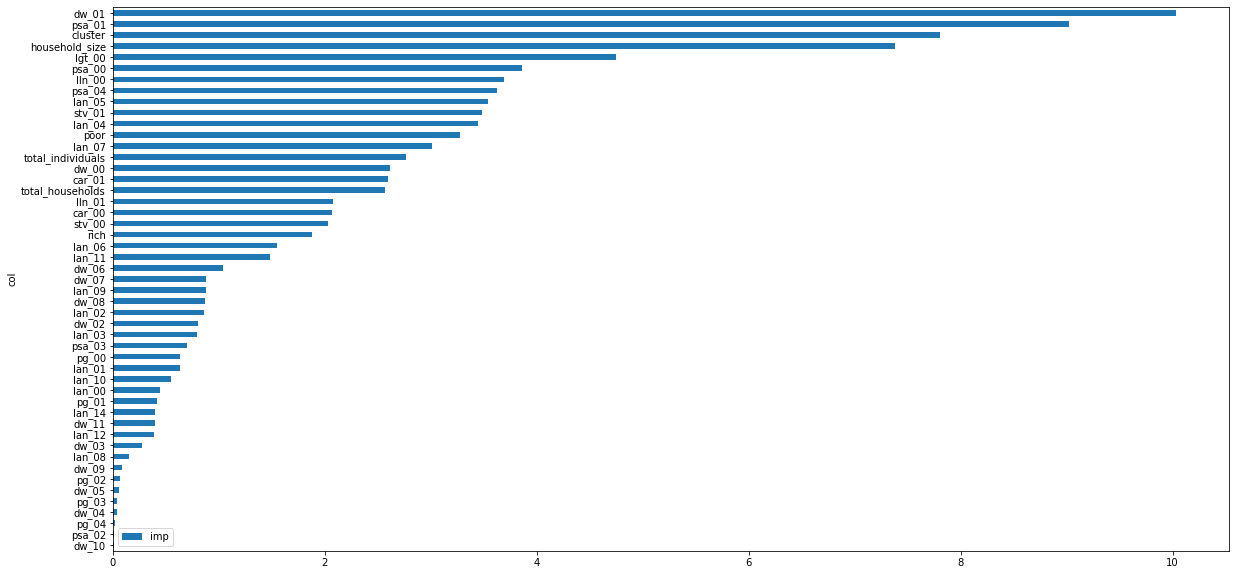

In [25]:
## Check for the feature importance 
fea_imp = pd.DataFrame({'imp':cat.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-60:]
_ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
plt.savefig('catboost_feature_importance.png')